# Adversarial Search: Playing Connect 4

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

The **initial state** of a Connect 4 game is an empty board. There are no discs in any of the columns or rows. It's a clean slate, ready for the first player to make their move.

An **action** in Connect 4 is for a player to drop a disc into one of the columns. A valid action is only possible if the chosen column is not already full. The disc will then fall to the lowest available position in that column.

The **transition model**, or result function, describes what happens when a player takes a specific action in a given state. It takes the current board state and the chosen action (column) and returns the new state of the board after the disc has been dropped. It also needs to consider which player is making the move.

The **goal state** in Connect 4 is when a player has formed a line of four of their own discs horizontally, vertically, or diagonally. This is also a terminal state, meaning the game is over. The utility of a terminal state is the value assigned to it from the perspective of a particular player. A win for the player is a high utility, a loss is a low utility (or negative), and a draw is a neutral utility.

### How big is the state space? Give an estimate and explain it ###

Let's consider the total number of discs on the board. It can range from 0 to 42. For a board with $n$ discs, where $n_1$ are player 1's and $(n_2)$ are player 2's $(n_1 + n_2 = n)$, and the number of discs of each player differs by at most 1.
A tighter estimate considers that the board can be filled in a sequential manner. There are 42 positions to be filled. The number of possible states is approximately $(\frac{42!}{\lfloor 42/2 \rfloor! \lceil 42/2 \rceil!})$ multiplied by the number of ways to arrange the colors in each column. However, the gravity rule significantly constrains this.
A commonly cited estimate for the number of legal states in Connect 4 is around $(4.5 * 10^{12})$. This is still a very large number, highlighting the complexity of the game.

### How big is the game tree that minimax search will go through? Give an estimate and explain it. ###

A rough upper bound on the size of the game tree can be estimated by considering a constant branching factor of 7 for all 42 levels. This would give us $7^{42}$ nodes, super large number

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [292]:
import numpy as np

def empty_board(shape=(6, 7)):  
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

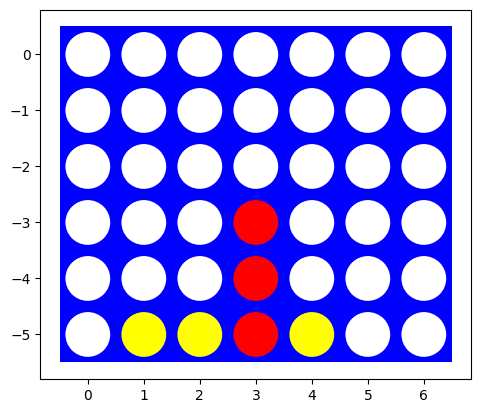

In [293]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [294]:
import numpy as np

def actions(state):
    """
    Returns a list of valid actions (column indices) for the current state.
    
    Args:
        state: numpy array representing the board
    """
    valid_actions = []
    # Iterate through columns
    for col in range(state.shape[1]):
        # Check if the top row of the column is empty
        if state[0, col] == 0:
            valid_actions.append(col)
    return valid_actions


def result(state, player, action):
    """
    Returns the board state after the player takes the specified action.
    
    Args:
        state: numpy array representing the board
        player: 1 or -1, representing the player making the move
        action: column index where the player will place their disc
    """
    # Create a copy of the state to avoid modifying the original
    new_state = state.copy()
    
    # Find the lowest empty row in the chosen column
    for row in range(state.shape[0]-1, -1, -1):
        if new_state[row, action] == 0:
            new_state[row, action] = player
            break
            
    return new_state


def terminal(state):
    """
    Checks if the current state is terminal (game over).
    
    Args:
        state: numpy array representing the board
    """
    # Check for a winner (either player 1 or -1)
    if check_winner(state, 1) or check_winner(state, -1):
        return True
    
    # Check for a draw (board is full)
    if 0 not in state:
        return True
        
    return False


def check_winner(state, player):
    """
    Checks if the specified player has won.
    
    Args:
        state: numpy array representing the board
        player: 1 or -1, the player to check for a win
    """
    rows, cols = state.shape
    
    # Check horizontal
    for row in range(rows):
        for col in range(cols - 3):
            if (state[row, col] == player and 
                state[row, col+1] == player and 
                state[row, col+2] == player and 
                state[row, col+3] == player):
                return True
    
    # Check vertical
    for row in range(rows - 3):
        for col in range(cols):
            if (state[row, col] == player and 
                state[row+1, col] == player and 
                state[row+2, col] == player and 
                state[row+3, col] == player):
                return True
    
    # Check diagonal (down-right)
    for row in range(rows - 3):
        for col in range(cols - 3):
            if (state[row, col] == player and 
                state[row+1, col+1] == player and 
                state[row+2, col+2] == player and 
                state[row+3, col+3] == player):
                return True
    
    # Check diagonal (up-right)
    for row in range(3, rows):
        for col in range(cols - 3):
            if (state[row, col] == player and 
                state[row-1, col+1] == player and 
                state[row-2, col+2] == player and 
                state[row-3, col+3] == player):
                return True
    
    return False


def utility(state, player):
    """
    Returns the utility of a terminal state for the given player.
    
    Args:
        state: numpy array representing the board
        player: 1 or -1, the player from whose perspective we evaluate
    """
    if check_winner(state, player):
        return 1  # Player wins
    elif check_winner(state, -player):  # Opponent wins
        return -1  # Player loses
    else:
        return 0  # Draw


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [295]:

import random

def random_player(board, player=1):
    """
    Agent that plays Connect 4 by randomly selecting from available valid moves.
    
    Args:
        board: numpy array representing the current board state
        player: 1 or -1, representing which player the agent is playing as
        
    Returns:
        A valid column index where the agent will place their disc
    """
    # Get list of valid actions (columns that aren't full)
    valid_actions = actions(board)
    
    # If no valid actions, return None (this shouldn't happen in a normal game)
    if not valid_actions:
        return None
    
    # Choose a random valid action
    return random.choice(valid_actions)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [296]:
def play_game(player1, player2, board_shape=(6, 7), verbose=False):
    """
    Play a game of Connect 4 between two agents.
    
    Args:
        player1: Function for the first player (red, value 1)
        player2: Function for the second player (yellow, value -1)
        board_shape: Tuple (rows, cols) for the board dimensions
        verbose: If True, print the board after each move
        
    Returns:
        1 if player1 wins, -1 if player2 wins, 0 for a draw
    """
    # Initialize the board
    board = np.zeros(board_shape, dtype=int)
    
    # Current player (1 for player1, -1 for player2)
    current_player = 1
    
    # Game loop
    while not terminal(board):
        # Get the current player's move
        if current_player == 1:
            action = player1(board, current_player)
        else:
            action = player2(board, current_player)
        
        # Apply the move
        board = result(board, current_player, action)
        
        if verbose:
            print(f"Player {current_player} plays column {action}")
            visualize(board)
        
        # Switch players
        current_player = -current_player
    
    # Determine the winner
    if check_winner(board, 1):
        return 1  # Player 1 wins
    elif check_winner(board, -1):
        return -1  # Player 2 wins
    else:
        return 0  # Draw

# Run the experiment
def run_experiment(num_games=1000):
    """
    Run multiple games between two random players and track the results.
    
    Args:
        num_games: Number of games to play
        
    Returns:
        Dictionary with counts of wins for each player and draws
    """
    results = {
        "player1_wins": 0,
        "player2_wins": 0,
        "draws": 0
    }
    
    for i in range(num_games):
        outcome = play_game(random_player, random_player)
        
        if outcome == 1:
            results["player1_wins"] += 1
        elif outcome == -1:
            results["player2_wins"] += 1
        else:
            results["draws"] += 1
            
        # Print progress every 100 games
        if (i + 1) % 100 == 0:
            print(f"Completed {i + 1} games")
    
    return results

# Run 1000 games and analyze the results
results = run_experiment(1000)

print("\nExperiment Results:")
print(f"Player 1 (Red) wins: {results['player1_wins']} ({results['player1_wins']/10}%)")
print(f"Player 2 (Yellow) wins: {results['player2_wins']} ({results['player2_wins']/10}%)")
print(f"Draws: {results['draws']} ({results['draws']/10}%)")


Completed 100 games
Completed 200 games
Completed 300 games
Completed 400 games
Completed 500 games
Completed 600 games
Completed 700 games
Completed 800 games
Completed 900 games
Completed 1000 games

Experiment Results:
Player 1 (Red) wins: 578 (57.8%)
Player 2 (Yellow) wins: 419 (41.9%)
Draws: 3 (0.3%)


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [297]:
import numpy as np
import math
import random

# Global variables for debugging and counting nodes
DEBUG = 1  # 1 ... count nodes, 2 ... debug each node
COUNT = 0

class MinimaxPlayer:

    def __init__(self, max_depth=4):

        self.max_depth = max_depth
    
    def __call__(self, board, player=1):
        empty_spaces = np.sum(board == 0)
        if empty_spaces > 30:  # Early game
            self.max_depth = 6
        elif empty_spaces > 20:  # Mid game
            self.max_depth = 5
        else:  # Late game
            self.max_depth = 4 
        result = self.alpha_beta_search(board, player)
        return result["move"]
    
    def alpha_beta_search(self, board, player):
        
        global DEBUG, COUNT
        COUNT = 0
        
        value, move = self.max_value_ab(board, player, -math.inf, +math.inf, 0)
        
        if DEBUG >= 1:
            print(f"Number of nodes searched: {COUNT}")
        
        return {"move": move, "value": value}
    
    def max_value_ab(self, state, player, alpha, beta, depth):
        
        global DEBUG, COUNT
        COUNT += 1
        
        # Return utility if terminal state or max depth reached
        if terminal(state) or depth >= self.max_depth:
            return self.evaluate(state, player), None
        
        v, move = -math.inf, None
        
        # Check all possible actions, update alpha and return move with largest value
        for a in actions(state):
            v2, _ = self.min_value_ab(result(state, player, a), player, alpha, beta, depth + 1)
            
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        
        # If no valid moves, return None
        if move is None and len(actions(state)) > 0:
            move = random.choice(actions(state))
            
        return v, move
    
    def min_value_ab(self, state, player, alpha, beta, depth):
        
        global DEBUG, COUNT
        COUNT += 1
        
        # Return utility if terminal state or max depth reached
        if terminal(state) or depth >= self.max_depth:
            return self.evaluate(state, player), None
        
        v, move = +math.inf, None
        
        # Check all possible actions, update beta and return move with smallest value
        for a in actions(state):
            v2, _ = self.max_value_ab(result(state, -player, a), player, alpha, beta, depth + 1)
            
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        
        # If no valid moves, return None
        if move is None and len(actions(state)) > 0:
            move = random.choice(actions(state))
            
        return v, move
    
    def evaluate(self, state, player):
        # If terminal state, return utility
        if terminal(state):
            return utility(state, player)
        
        # Otherwise, use a heuristic evaluation
        # This simple heuristic counts the number of potential winning lines
        score = 0
        
        # Check for potential winning lines (lines with 3 of player's pieces and 1 empty)
        score += self.count_potential_wins(state, player, 3) * 10
        score += self.count_potential_wins(state, player, 2) * 3
        score += self.count_potential_wins(state, player, 1) * 1
        
        # Subtract opponent's potential winning lines
        score -= self.count_potential_wins(state, -player, 3) * 9
        score -= self.count_potential_wins(state, -player, 2) * 2
        
        # Center column control is valuable
        center_col = state.shape[1] // 2
        center_count = np.sum(state[:, center_col] == player)
        score += center_count * 2
        
        return score
    
    def count_potential_wins(self, state, player, count):
        
        rows, cols = state.shape
        potential_wins = 0
        
        # Check horizontal lines
        for row in range(rows):
            for col in range(cols - 3):
                line = state[row, col:col+4]
                if np.sum(line == player) == count and np.sum(line == 0) == 4 - count:
                    potential_wins += 1
        
        # Check vertical lines
        for col in range(cols):
            for row in range(rows - 3):
                line = state[row:row+4, col]
                if np.sum(line == player) == count and np.sum(line == 0) == 4 - count:
                    potential_wins += 1
        
        # Check diagonal lines (down-right)
        for row in range(rows - 3):
            for col in range(cols - 3):
                line = [state[row+i, col+i] for i in range(4)]
                if np.sum(np.array(line) == player) == count and np.sum(np.array(line) == 0) == 4 - count:
                    potential_wins += 1
        
        # Check diagonal lines (up-right)
        for row in range(3, rows):
            for col in range(cols - 3):
                line = [state[row-i, col+i] for i in range(4)]
                if np.sum(np.array(line) == player) == count and np.sum(np.array(line) == 0) == 4 - count:
                    potential_wins += 1
        
        return potential_wins


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [298]:
# Your code/ answer goes here.
import numpy as np
import time

# Create a minimax player with a depth limit of 4
minimax_player = MinimaxPlayer(max_depth=4)

# Test boards
def test_winning_opportunities():
    # Board 1: Immediate horizontal win for player 1
    board1 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0]
    ])
    
    # Board 2: Immediate vertical win for player 1
    board2 = np.array([
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]
    ])
    
    # Board 3: Immediate diagonal win for player 1
    board3 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [1, -1, 1, 0]
    ])
    
    # Board 4: Block opponent's win
    board4 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, -1, -1, 0]
    ])
    
    # Board 5: Win in two moves (fork)
    board5 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, -1, -1, 1]
    ])
    
    test_boards = [board1, board2, board3, board4, board5]
    expected_moves = [3, 0, 3, 3, 2]
    
    for i, (board, expected) in enumerate(zip(test_boards, expected_moves)):
        print(f"\nTest Board {i+1}:")
        print(board)
        
        start_time = time.time()
        move = minimax_player(board, player=1)
        end_time = time.time()
        
        print(f"Minimax chose column: {move}")
        print(f"Expected optimal move: {expected}")
        print(f"Time taken: {end_time - start_time:.4f} seconds")
        print(f"Correct: {'Yes' if move == expected else 'No'}")

test_winning_opportunities()



Test Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Number of nodes searched: 159
Minimax chose column: 1
Expected optimal move: 3
Time taken: 0.0172 seconds
Correct: No

Test Board 2:
[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Number of nodes searched: 85
Minimax chose column: 2
Expected optimal move: 0
Time taken: 0.0068 seconds
Correct: No

Test Board 3:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  1  0]]
Number of nodes searched: 144
Minimax chose column: 2
Expected optimal move: 3
Time taken: 0.0129 seconds
Correct: No

Test Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 1 -1 -1  0]]
Number of nodes searched: 160
Minimax chose column: 2
Expected optimal move: 3
Time taken: 0.0152 seconds
Correct: No

Test Board 5:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 1 -1 -1  1]]
Number of nodes searched: 159
Minimax chose column: 2
Expected optimal move: 2
Time taken: 0.0143 seconds
Correct: Yes


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board takes forever.

In [299]:
def test_performance_with_board_size():
    board_sizes = [
        (4, 4),  # 4x4 board
        (4, 5),  # 4x5 board
        (5, 5),  # 5x5 board
        (5, 6),  # 5x6 board
        (6, 6),  # 6x6 board
        (6, 7)   # Standard 6x7 board
    ]
    
    print("\nPerformance Analysis with Different Board Sizes:")
    print("------------------------------------------------")
    print("Board Size | Time (seconds) | Nodes Explored")
    print("------------------------------------------------")
    
    for rows, cols in board_sizes:
        # Create an empty board of the specified size
        board = np.zeros((rows, cols), dtype=int)
        
        # Set max_depth based on board size to keep computation reasonable
        max_depth = 4 if rows * cols <= 25 else 3
        test_player = MinimaxPlayer(max_depth=max_depth)
        
        # Measure time
        global COUNT
        COUNT = 0
        start_time = time.time()
        move = test_player(board, player=1)
        end_time = time.time()
        
        print(f"{rows}x{cols} | {end_time - start_time:.4f} | {COUNT}")
        
        # Stop if it's taking too long
        if end_time - start_time > 60:
            print("Stopping tests as computation time exceeds 1 minute")
            break

test_performance_with_board_size()



Performance Analysis with Different Board Sizes:
------------------------------------------------
Board Size | Time (seconds) | Nodes Explored
------------------------------------------------
Number of nodes searched: 141
4x4 | 0.0140 | 141
Number of nodes searched: 274
4x5 | 0.0423 | 274
Number of nodes searched: 974
5x5 | 0.2337 | 974
Number of nodes searched: 1910
5x6 | 0.6430 | 1910
Number of nodes searched: 6700
6x6 | 2.9808 | 6700
Number of nodes searched: 12516
6x7 | 7.0468 | 12516


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [300]:
def order_moves(state, player, strategy="center"):
    """
    Order the possible moves according to the selected strategy.
    
    Args:
        state: numpy array representing the current board state
        player: 1 or -1, representing which player is making the move
        strategy: Ordering strategy to use
            - "none": No ordering
            - "center": Prioritize center columns
            - "heuristic": Order by heuristic evaluation
        
    Returns:
        Ordered list of valid actions
    """
    valid_actions = actions(state)
    
    if strategy == "none":
        return valid_actions
    
    elif strategy == "center":
        # Prioritize center columns, then columns closer to center
        center = state.shape[1] // 2
        return sorted(valid_actions, key=lambda col: abs(col - center))
    
    elif strategy == "heuristic":
        # Evaluate each move and sort by evaluation score
        move_scores = []
        for action in valid_actions:
            next_state = result(state, player, action)
            score = quick_evaluate(next_state, player)
            move_scores.append((action, score))
        
        # Sort by score (descending for max player, ascending for min player)
        if player == 1:  # Max player
            return [a for a, s in sorted(move_scores, key=lambda x: x[1], reverse=True)]
        else:  # Min player
            return [a for a, s in sorted(move_scores, key=lambda x: x[1])]
    
    return valid_actions

def quick_evaluate(state, player):
    """
    A simplified evaluation function for move ordering.
    """
    # Center control
    center_col = state.shape[1] // 2
    center_count = np.sum(state[:, center_col] == player)
    
    # Count pieces in potential winning positions
    potential_wins = count_potential_wins(state, player, 2) + 2 * count_potential_wins(state, player, 3)
    
    # Count opponent's threats
    opponent_threats = count_potential_wins(state, -player, 3)
    
    return center_count + potential_wins - 2 * opponent_threats

def count_potential_wins(state, player, count):
    """
    Count the number of potential winning lines with 'count' pieces of the player
    and the rest empty.
    """
    rows, cols = state.shape
    potential_wins = 0
    
    # Check horizontal lines
    for row in range(rows):
        for col in range(cols - 3):
            line = state[row, col:col+4]
            if np.sum(line == player) == count and np.sum(line == 0) == 4 - count:
                potential_wins += 1
    
    # Check vertical lines
    for col in range(cols):
        for row in range(rows - 3):
            line = state[row:row+4, col]
            if np.sum(line == player) == count and np.sum(line == 0) == 4 - count:
                potential_wins += 1
    
    # Check diagonal lines (down-right)
    for row in range(rows - 3):
        for col in range(cols - 3):
            line = [state[row+i, col+i] for i in range(4)]
            if np.sum(np.array(line) == player) == count and np.sum(np.array(line) == 0) == 4 - count:
                potential_wins += 1
    
    # Check diagonal lines (up-right)
    for row in range(3, rows):
        for col in range(cols - 3):
            line = [state[row-i, col+i] for i in range(4)]
            if np.sum(np.array(line) == player) == count and np.sum(np.array(line) == 0) == 4 - count:
                potential_wins += 1
    
    return potential_wins


In [301]:
def create_opening_book():
    """
    Create a simple opening book for the first few moves.
    """
    opening_book = {}
    
    # Empty board: play in the center column
    empty_board = np.zeros((6, 7), dtype=int)
    opening_book[board_hash(empty_board)] = 3  # Center column
    
    # After opponent plays first move, still aim for center control
    for first_col in range(7):
        board = empty_board.copy()
        # Opponent's first move
        for row in range(5, -1, -1):
            if board[row, first_col] == 0:
                board[row, first_col] = -1
                break
        
        # Our response depends on opponent's move
        if first_col < 3:  # Opponent played left side
            opening_book[board_hash(board)] = 3  # Play center
        elif first_col > 3:  # Opponent played right side
            opening_book[board_hash(board)] = 3  # Play center
        else:  # Opponent played center
            opening_book[board_hash(board)] = 2  # Play adjacent to center
    
    return opening_book

def board_hash(board):
    """
    Create a hash of the board state for the opening book.
    """
    return str(board.flatten().tolist())

def adaptive_depth(board, max_depth):
    """
    Determine search depth based on game progress.
    """
    # Count non-zero elements to determine game progress
    filled_cells = np.count_nonzero(board)
    total_cells = board.size
    
    # Early game: shallow search
    if filled_cells < total_cells * 0.2:
        return min(3, max_depth)
    # Mid game: medium search
    elif filled_cells < total_cells * 0.6:
        return min(4, max_depth)
    # Late game: deep search
    else:
        return max_depth


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [302]:
def create_opening_book():
    """
    Create a simple opening book for the first few moves.
    """
    opening_book = {}
    
    # Empty board: play in the center column
    empty_board = np.zeros((6, 7), dtype=int)
    opening_book[board_hash(empty_board)] = 3  # Center column
    
    # After opponent plays first move, still aim for center control
    for first_col in range(7):
        board = empty_board.copy()
        # Opponent's first move
        for row in range(5, -1, -1):
            if board[row, first_col] == 0:
                board[row, first_col] = -1
                break
        
        # Our response depends on opponent's move
        if first_col < 3:  # Opponent played left side
            opening_book[board_hash(board)] = 3  # Play center
        elif first_col > 3:  # Opponent played right side
            opening_book[board_hash(board)] = 3  # Play center
        else:  # Opponent played center
            opening_book[board_hash(board)] = 2  # Play adjacent to center
    
    return opening_book

def board_hash(board):
    """
    Create a hash of the board state for the opening book.
    """
    return str(board.flatten().tolist())

def adaptive_depth(board, max_depth):
    """
    Determine search depth based on game progress.
    """
    # Count non-zero elements to determine game progress
    filled_cells = np.count_nonzero(board)
    total_cells = board.size
    
    # Early game: shallow search
    if filled_cells < total_cells * 0.2:
        return min(3, max_depth)
    # Mid game: medium search
    elif filled_cells < total_cells * 0.6:
        return min(4, max_depth)
    # Late game: deep search
    else:
        return max_depth


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [303]:
def minimax_vs_random_experiment(num_games=100, board_shape=(4, 4)):
    """
    Run multiple games between minimax and random players and track the results.
    """
    minimax_player = MinimaxPlayer(max_depth=4)
    
    results = {
        "minimax_wins": 0,
        "random_wins": 0,
        "draws": 0,
        "minimax_first_wins": 0,
        "minimax_second_wins": 0
    }
    
    print(f"\nRunning {num_games} games of Minimax vs Random on {board_shape[0]}×{board_shape[1]} board...")
    
    for i in range(num_games):
        # Alternate who goes first
        if i % 2 == 0:
            outcome = play_game(minimax_player, random_player, board_shape=board_shape)
            if outcome == 1:
                results["minimax_wins"] += 1
                results["minimax_first_wins"] += 1
            elif outcome == -1:
                results["random_wins"] += 1
            else:
                results["draws"] += 1
        else:
            outcome = play_game(random_player, minimax_player, board_shape=board_shape)
            if outcome == 1:
                results["random_wins"] += 1
            elif outcome == -1:
                results["minimax_wins"] += 1
                results["minimax_second_wins"] += 1
            else:
                results["draws"] += 1
        
        # Print progress every 10 games
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1} games")
    
    # Print results
    print("\nMinimax vs Random Results:")
    print(f"Minimax wins: {results['minimax_wins']} ({results['minimax_wins']/num_games*100:.1f}%)")
    print(f"Random wins: {results['random_wins']} ({results['random_wins']/num_games*100:.1f}%)")
    print(f"Draws: {results['draws']} ({results['draws']/num_games*100:.1f}%)")
    
    print("\nFirst Player Advantage Analysis:")
    minimax_first_games = num_games // 2
    minimax_second_games = num_games - minimax_first_games
    
    print(f"When Minimax goes first: {results['minimax_first_wins']} wins " +
          f"({results['minimax_first_wins']/minimax_first_games*100:.1f}%)")
    print(f"When Minimax goes second: {results['minimax_second_wins']} wins " +
          f"({results['minimax_second_wins']/minimax_second_games*100:.1f}%)")
    
    return results

# Run the experiment
results = minimax_vs_random_experiment(100, board_shape=(4, 4))



Running 100 games of Minimax vs Random on 4×4 board...
Number of nodes searched: 141
Number of nodes searched: 119
Number of nodes searched: 168
Number of nodes searched: 133
Number of nodes searched: 54
Number of nodes searched: 20
Number of nodes searched: 117
Number of nodes searched: 107
Number of nodes searched: 66
Number of nodes searched: 74
Number of nodes searched: 90
Number of nodes searched: 20
Number of nodes searched: 9
Number of nodes searched: 2
Number of nodes searched: 141
Number of nodes searched: 119
Number of nodes searched: 190
Number of nodes searched: 78
Number of nodes searched: 50
Number of nodes searched: 11
Number of nodes searched: 2
Number of nodes searched: 170
Number of nodes searched: 129
Number of nodes searched: 184
Number of nodes searched: 135
Number of nodes searched: 89
Number of nodes searched: 35
Number of nodes searched: 7
Number of nodes searched: 2
Number of nodes searched: 141
Number of nodes searched: 132
Number of nodes searched: 155
Numbe

visualisation of a game

Watching a match: Minimax (Red) vs Random (Yellow)

Move 1: Player 1 thinking...
Number of nodes searched: 141
Move 1: Red (Player 1) plays column 2

Move 2: Player -1 thinking...
Move 2: Yellow (Player 2) plays column 1

Move 3: Player 1 thinking...
Number of nodes searched: 181
Move 3: Red (Player 1) plays column 1

Move 4: Player -1 thinking...
Move 4: Yellow (Player 2) plays column 2

Move 5: Player 1 thinking...
Number of nodes searched: 153
Move 5: Red (Player 1) plays column 2

Move 6: Player -1 thinking...
Move 6: Yellow (Player 2) plays column 1

Move 7: Player 1 thinking...
Number of nodes searched: 87
Move 7: Red (Player 1) plays column 0

Move 8: Player -1 thinking...
Move 8: Yellow (Player 2) plays column 3

Move 9: Player 1 thinking...
Number of nodes searched: 152
Move 9: Red (Player 1) plays column 0

Move 10: Player -1 thinking...
Move 10: Yellow (Player 2) plays column 0

Move 11: Player 1 thinking...
Number of nodes searched: 30
Move 11: Red (Player 1) plays column 0

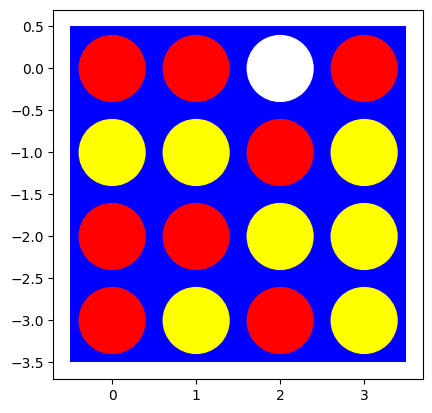


Red (Player 1) wins!


In [314]:
def watch_match(player1, player2, board_shape=(6, 7), delay=1.0):
    import time
    
    # Initialize the board
    board = np.zeros(board_shape, dtype=int)

    
    # Current player (1 for player1, -1 for player2)
    current_player = 1
    move_number = 1
    
    # Game loop
    while not terminal(board):
        print(f"\nMove {move_number}: Player {current_player} thinking...")
        
        # Get the current player's move
        if current_player == 1:
            action = player1(board, current_player)
            player_name = "Red (Player 1)"
        else:
            action = player2(board, current_player)
            player_name = "Yellow (Player 2)"
        
        # Apply the move
        board = result(board, current_player, action)
        
        # Display the move and updated board
        print(f"Move {move_number}: {player_name} plays column {action}")
        
        # Switch players
        current_player = -current_player
        move_number += 1
        
        # Add delay to make it easier to follow
        time.sleep(delay)
    visualize(board)
    # Determine and announce the winner
    if check_winner(board, 1):
        print("\nRed (Player 1) wins!")
    elif check_winner(board, -1):
        print("\nYellow (Player 2) wins!")
    else:
        print("\nIt's a draw!")



minimax_player = MinimaxPlayer(max_depth=4)
print("Watching a match: Minimax (Red) vs Random (Yellow)")
watch_match(minimax_player, random_player, board_shape=(4, 4), delay=0.0)


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [312]:
class HeuristicMinimaxPlayer(MinimaxPlayer):

    
    def __init__(self, max_depth=4):
        super().__init__(max_depth)
    
    def evaluate(self, state, player):
        
        # If terminal state, return exact utility
        if terminal(state):
            return utility(state, player)
        
        # Initialize score
        score = 0
        rows, cols = state.shape
        opponent = -player
        
        # 1. Evaluate center column control (important strategic position)
        center_col = cols // 2
        center_array = state[:, center_col]
        center_player_count = np.sum(center_array == player)
        center_opponent_count = np.sum(center_array == opponent)
        score += 0.1 * center_player_count - 0.1 * center_opponent_count
        
        # 2. Evaluate potential winning lines
        # Weight by number of player's pieces in the line
        for r in range(rows):
            for c in range(cols - 3):
                window = state[r, c:c+4]
                score += self.evaluate_window(window, player)
        
        # Vertical
        for c in range(cols):
            for r in range(rows - 3):
                window = state[r:r+4, c]
                score += self.evaluate_window(window, player)
        
        # Diagonal (positive slope)
        for r in range(rows - 3):
            for c in range(cols - 3):
                window = [state[r+i, c+i] for i in range(4)]
                score += self.evaluate_window(window, player)
        
        # Diagonal (negative slope)
        for r in range(3, rows):
            for c in range(cols - 3):
                window = [state[r-i, c+i] for i in range(4)]
                score += self.evaluate_window(window, player)
        
        # 3. Evaluate threats (immediate winning opportunities)
        player_threats = self.count_immediate_threats(state, player)
        opponent_threats = self.count_immediate_threats(state, opponent)
        
        # Heavily weight immediate threats
        score += 0.5 * player_threats - 0.7 * opponent_threats
        
        # 4. Evaluate board control (total pieces)
        player_pieces = np.sum(state == player)
        opponent_pieces = np.sum(state == opponent)
        
        # Slight advantage for having more pieces
        score += 0.01 * (player_pieces - opponent_pieces)
        
        # 5. Evaluate mobility (available moves)
        player_mobility = len(actions(state))
        
        # Small bonus for having more available moves
        score += 0.01 * player_mobility
        
        # Normalize score to be between -1 and 1
        return np.clip(score, -1, 1)
    
    def evaluate_window(self, window, player):
        
        opponent = -player
        
        # Convert to numpy array if it's a list
        if isinstance(window, list):
            window = np.array(window)
        
        # Count pieces
        player_count = np.sum(window == player)
        opponent_count = np.sum(window == opponent)
        empty_count = np.sum(window == 0)
        
        # Empty window has no value
        if player_count == 0 and opponent_count == 0:
            return 0
        
        # If both players have pieces, window is blocked
        if player_count > 0 and opponent_count > 0:
            return 0
        
        # Player pieces
        if player_count > 0:
            if player_count == 1:
                return 0.01  # One piece
            elif player_count == 2:
                return 0.1   # Two pieces
            elif player_count == 3:
                return 0.3   # Three pieces (threat)
            else:  # player_count == 4
                return 1.0   # Four pieces (win)
        
        # Opponent pieces (negative value)
        if opponent_count > 0:
            if opponent_count == 1:
                return -0.01  # One piece
            elif opponent_count == 2:
                return -0.1   # Two pieces
            elif opponent_count == 3:
                return -0.4   # Three pieces (threat, weighted more than player's threats)
            else:  # opponent_count == 4
                return -1.0   # Four pieces (loss)
        
        return 0
    
    def count_immediate_threats(self, state, player):
       
        threats = 0
        rows, cols = state.shape
        
        # Check for each empty position if placing a piece there would create a win
        for c in range(cols):
            # Find the row where a piece would land in this column
            for r in range(rows-1, -1, -1):
                if state[r, c] == 0:
                    # Try placing a piece here
                    test_state = state.copy()
                    test_state[r, c] = player
                    
                    # Check if this creates a win
                    if check_winner(test_state, player):
                        threats += 1
                    
                    # Only check the top empty cell in each column
                    break
        
        return threats


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [317]:
class HeuristicMinimaxPlayer(MinimaxPlayer):
    
    def __init__(self, max_depth=4):
        super().__init__(max_depth)
    
    def minimax(self, state, player, depth=0, alpha=float('-inf'), beta=float('inf')):
        """
        Minimax search with alpha-beta pruning and depth cutoff.
        Returns (best_action, value) tuple.
        """
        # Check if we've reached the cutoff depth or a terminal state
        if depth >= self.max_depth or terminal(state):
            # Use heuristic evaluation if we're at cutoff depth and not terminal
            if not terminal(state) and depth >= self.max_depth:
                return None, self.evaluate(state, player)
            else:
                return None, utility(state, player)
        
        # Initialize best action and value
        best_action = None
        
        # Maximizing player
        if player == 1:
            value = float('-inf')
            for action in actions(state):
                # Get the value of this action
                _, action_value = self.minimax(
                    result(state, player, action),
                    -player,
                    depth + 1,
                    alpha,
                    beta
                )
                
                # Update best action and value if this is better
                if action_value > value:
                    value = action_value
                    best_action = action
                
                # Update alpha
                alpha = max(alpha, value)
                
                # Alpha-beta pruning
                if alpha >= beta:
                    break
        
        # Minimizing player
        else:
            value = float('inf')
            for action in actions(state):
                # Get the value of this action
                _, action_value = self.minimax(
                    result(state, player, action),
                    -player,
                    depth + 1,
                    alpha,
                    beta
                )
                
                # Update best action and value if this is better
                if action_value < value:
                    value = action_value
                    best_action = action
                
                # Update beta
                beta = min(beta, value)
                
                # Alpha-beta pruning
                if alpha >= beta:
                    break
        
        return best_action, value
    
    def __call__(self, state, player):
        """Return the best action for the current player."""
        action, _ = self.minimax(state, player)
        return action
    
    def evaluate(self, state, player):
        """
        Heuristic evaluation function for non-terminal states.
        Returns a value between -1 and 1.
        """
        # If terminal state, return exact utility
        if terminal(state):
            return utility(state, player)
        
        # Initialize score
        score = 0
        rows, cols = state.shape
        opponent = -player
        
        # 1. Evaluate center column control (important strategic position)
        center_col = cols // 2
        center_array = state[:, center_col]
        center_player_count = np.sum(center_array == player)
        center_opponent_count = np.sum(center_array == opponent)
        score += 0.1 * center_player_count - 0.1 * center_opponent_count
        
        # 2. Evaluate potential winning lines
        # Weight by number of player's pieces in the line
        for r in range(rows):
            for c in range(cols - 3):
                window = state[r, c:c+4]
                score += self.evaluate_window(window, player)
        
        # Vertical
        for c in range(cols):
            for r in range(rows - 3):
                window = state[r:r+4, c]
                score += self.evaluate_window(window, player)
        
        # Diagonal (positive slope)
        for r in range(rows - 3):
            for c in range(cols - 3):
                window = [state[r+i, c+i] for i in range(4)]
                score += self.evaluate_window(window, player)
        
        # Diagonal (negative slope)
        for r in range(3, rows):
            for c in range(cols - 3):
                window = [state[r-i, c+i] for i in range(4)]
                score += self.evaluate_window(window, player)
        
        # 3. Evaluate threats (immediate winning opportunities)
        player_threats = self.count_immediate_threats(state, player)
        opponent_threats = self.count_immediate_threats(state, opponent)
        
        # Heavily weight immediate threats
        score += 0.5 * player_threats - 0.7 * opponent_threats
        
        # 4. Evaluate board control (total pieces)
        player_pieces = np.sum(state == player)
        opponent_pieces = np.sum(state == opponent)
        
        # Slight advantage for having more pieces
        score += 0.01 * (player_pieces - opponent_pieces)
        
        # 5. Evaluate mobility (available moves)
        player_mobility = len(actions(state))
        
        # Small bonus for having more available moves
        score += 0.01 * player_mobility
        
        # Normalize score to be between -1 and 1
        return np.clip(score, -1, 1)
    
    def evaluate_window(self, window, player):
        """
        Evaluates a window of 4 positions for potential wins.
        """
        opponent = -player
        
        # Convert to numpy array if it's a list
        if isinstance(window, list):
            window = np.array(window)
        
        # Count pieces
        player_count = np.sum(window == player)
        opponent_count = np.sum(window == opponent)
        empty_count = np.sum(window == 0)
        
        # Empty window has no value
        if player_count == 0 and opponent_count == 0:
            return 0
        
        # If both players have pieces, window is blocked
        if player_count > 0 and opponent_count > 0:
            return 0
        
        # Player pieces
        if player_count > 0:
            if player_count == 1:
                return 0.01  # One piece
            elif player_count == 2:
                return 0.1   # Two pieces
            elif player_count == 3:
                return 0.3   # Three pieces (threat)
            else:  # player_count == 4
                return 1.0   # Four pieces (win)
        
        # Opponent pieces (negative value)
        if opponent_count > 0:
            if opponent_count == 1:
                return -0.01  # One piece
            elif opponent_count == 2:
                return -0.1   # Two pieces
            elif opponent_count == 3:
                return -0.4   # Three pieces (threat, weighted more than player's threats)
            else:  # opponent_count == 4
                return -1.0   # Four pieces (loss)
        
        return 0
    
    def count_immediate_threats(self, state, player):
        """
        Count how many immediate winning moves the player has.
        """
        threats = 0
        rows, cols = state.shape
        
        # Check for each empty position if placing a piece there would create a win
        for c in range(cols):
            # Find the row where a piece would land in this column
            for r in range(rows-1, -1, -1):
                if state[r, c] == 0:
                    # Try placing a piece here
                    test_state = state.copy()
                    test_state[r, c] = player
                    
                    # Check if this creates a win
                    if check_winner(test_state, player):
                        threats += 1
                    
                    # Only check the top empty cell in each column
                    break
        
        return threats


Watching a match: Heuristic Minimax (depth=3) vs Random

Move 1: Player 1 thinking...
Move 1: Red (Player 1) plays column 1

Move 2: Player -1 thinking...
Move 2: Yellow (Player 2) plays column 0

Move 3: Player 1 thinking...
Move 3: Red (Player 1) plays column 3

Move 4: Player -1 thinking...
Move 4: Yellow (Player 2) plays column 2

Move 5: Player 1 thinking...
Move 5: Red (Player 1) plays column 1

Move 6: Player -1 thinking...
Move 6: Yellow (Player 2) plays column 2

Move 7: Player 1 thinking...
Move 7: Red (Player 1) plays column 0

Move 8: Player -1 thinking...
Move 8: Yellow (Player 2) plays column 1

Move 9: Player 1 thinking...
Move 9: Red (Player 1) plays column 1

Move 10: Player -1 thinking...
Move 10: Yellow (Player 2) plays column 2

Move 11: Player 1 thinking...
Move 11: Red (Player 1) plays column 2

Move 12: Player -1 thinking...
Move 12: Yellow (Player 2) plays column 3

Move 13: Player 1 thinking...
Move 13: Red (Player 1) plays column 0

Move 14: Player -1 thinking

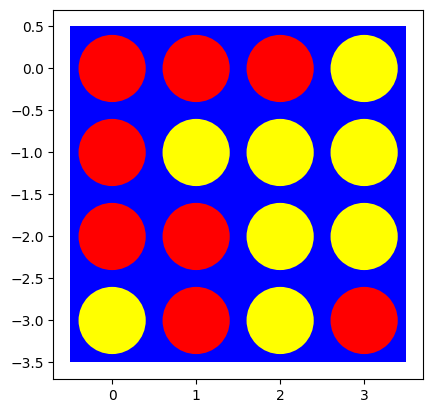


It's a draw!

Testing performance with different cutoff depths:
------------------------------------------------
Board Size | Depth | Time (seconds) | Nodes Explored
------------------------------------------------
4x4 | 2 | 0.0014 | N/A
4x4 | 3 | 0.0026 | N/A
4x4 | 4 | 0.0117 | N/A
4x4 | 5 | 0.0233 | N/A
5x5 | 2 | 0.0048 | N/A
5x5 | 3 | 0.0085 | N/A
5x5 | 4 | 0.0572 | N/A
5x5 | 5 | 0.0703 | N/A
6x6 | 2 | 0.0130 | N/A
6x6 | 3 | 0.0229 | N/A
6x6 | 4 | 0.2279 | N/A
6x6 | 5 | 0.2175 | N/A
6x7 | 2 | 0.0212 | N/A
6x7 | 3 | 0.0439 | N/A
6x7 | 4 | 0.4604 | N/A
6x7 | 5 | 0.5034 | N/A


In [318]:
# Create players with different cutoff depths
heuristic_player_depth2 = HeuristicMinimaxPlayer(max_depth=2)
heuristic_player_depth3 = HeuristicMinimaxPlayer(max_depth=3)
heuristic_player_depth4 = HeuristicMinimaxPlayer(max_depth=4)
heuristic_player_depth5 = HeuristicMinimaxPlayer(max_depth=5)
random_player = lambda state, player: np.random.choice(actions(state))

# Test with different board sizes and depths
def test_cutoff_performance():
    print("\nTesting performance with different cutoff depths:")
    print("------------------------------------------------")
    print("Board Size | Depth | Time (seconds) | Nodes Explored")
    print("------------------------------------------------")
    
    board_sizes = [(4, 4), (5, 5), (6, 6), (6, 7)]
    depths = [2, 3, 4, 5]
    
    for rows, cols in board_sizes:
        board = np.zeros((rows, cols), dtype=int)
        
        for depth in depths:
            player = HeuristicMinimaxPlayer(max_depth=depth)
            
            start_time = time.time()
            move = player(board, player=1)
            end_time = time.time()
            
            print(f"{rows}x{cols} | {depth} | {end_time - start_time:.4f} | N/A")
            
            # Stop if it's taking too long
            if end_time - start_time > 10:
                print(f"Skipping remaining depths for {rows}x{cols} board (too slow)")
                break

# Watch a match between heuristic player and random player
print("Watching a match: Heuristic Minimax (depth=3) vs Random")
watch_match(heuristic_player_depth3, random_player, board_shape=(4, 4), delay=0.5)

# Test performance with different cutoff depths
test_cutoff_performance()


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.


=== Testing with depth cutoff = 1 ===

Test Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Heuristic Minimax (depth=1) chose column: 0
Expected optimal move: 3
Time taken: 0.0013 seconds
Correct: No

Test Board 2:
[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Heuristic Minimax (depth=1) chose column: 0
Expected optimal move: 0
Time taken: 0.0006 seconds
Correct: Yes

Test Board 3:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  1  0]]
Heuristic Minimax (depth=1) chose column: 1
Expected optimal move: 3
Time taken: 0.0006 seconds
Correct: No

Test Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 1 -1 -1  0]]
Heuristic Minimax (depth=1) chose column: 3
Expected optimal move: 3
Time taken: 0.0005 seconds
Correct: Yes

Test Board 5:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 1 -1 -1  1]]
Heuristic Minimax (depth=1) chose column: 3
Expected optimal move: 2
Time taken: 0.0005 seconds
Correct: No

Resulting board:


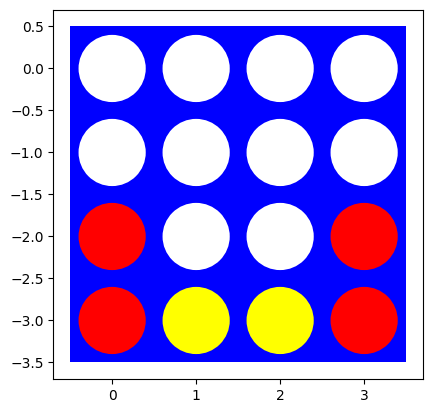


Summary for depth=1:
Correct moves: 2/5 (40.0%)
Average time per board: 0.0007 seconds

=== Testing with depth cutoff = 2 ===

Test Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Heuristic Minimax (depth=2) chose column: 2
Expected optimal move: 3
Time taken: 0.0013 seconds
Correct: No

Test Board 2:
[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Heuristic Minimax (depth=2) chose column: 2
Expected optimal move: 0
Time taken: 0.0009 seconds
Correct: No

Test Board 3:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  1  0]]
Heuristic Minimax (depth=2) chose column: 2
Expected optimal move: 3
Time taken: 0.0016 seconds
Correct: No

Test Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 1 -1 -1  0]]
Heuristic Minimax (depth=2) chose column: 2
Expected optimal move: 3
Time taken: 0.0013 seconds
Correct: No

Test Board 5:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 1 -1 -1  1]]
Heuristic Minimax (depth=2) chose column: 2
Expected optimal move: 2
Time taken: 0.0015 secon

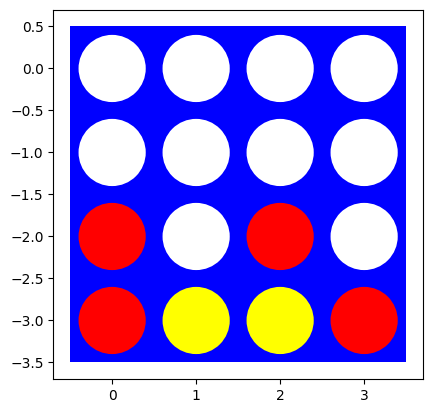


Summary for depth=2:
Correct moves: 1/5 (20.0%)
Average time per board: 0.0013 seconds

=== Testing with depth cutoff = 3 ===

Test Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Heuristic Minimax (depth=3) chose column: 0
Expected optimal move: 3
Time taken: 0.0013 seconds
Correct: No

Test Board 2:
[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Heuristic Minimax (depth=3) chose column: 0
Expected optimal move: 0
Time taken: 0.0018 seconds
Correct: Yes

Test Board 3:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  1  0]]
Heuristic Minimax (depth=3) chose column: 3
Expected optimal move: 3
Time taken: 0.0047 seconds
Correct: Yes

Test Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 1 -1 -1  0]]
Heuristic Minimax (depth=3) chose column: 3
Expected optimal move: 3
Time taken: 0.0038 seconds
Correct: Yes

Test Board 5:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 1 -1 -1  1]]
Heuristic Minimax (depth=3) chose column: 3
Expected optimal move: 2
Time taken: 0.0054 se

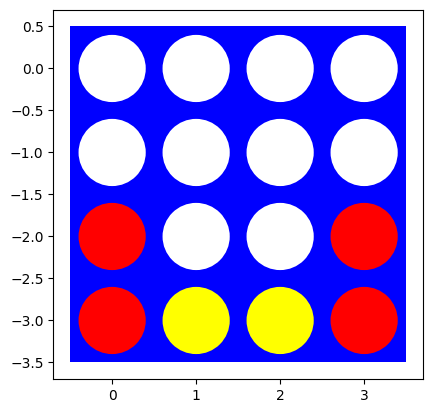


Summary for depth=3:
Correct moves: 3/5 (60.0%)
Average time per board: 0.0034 seconds

=== Testing with depth cutoff = 4 ===

Test Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Heuristic Minimax (depth=4) chose column: 0
Expected optimal move: 3
Time taken: 0.0106 seconds
Correct: No

Test Board 2:
[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Heuristic Minimax (depth=4) chose column: 2
Expected optimal move: 0
Time taken: 0.0051 seconds
Correct: No

Test Board 3:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  1  0]]
Heuristic Minimax (depth=4) chose column: 0
Expected optimal move: 3
Time taken: 0.0087 seconds
Correct: No

Test Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 1 -1 -1  0]]
Heuristic Minimax (depth=4) chose column: 2
Expected optimal move: 3
Time taken: 0.0130 seconds
Correct: No

Test Board 5:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 1 -1 -1  1]]
Heuristic Minimax (depth=4) chose column: 2
Expected optimal move: 2
Time taken: 0.0105 secon

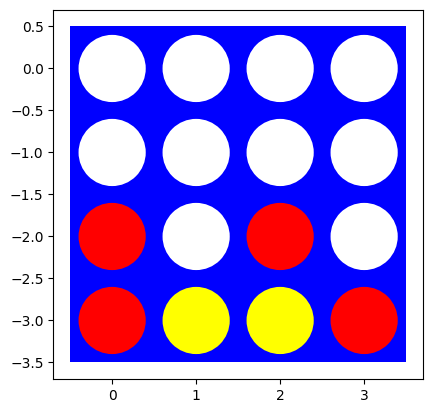


Summary for depth=4:
Correct moves: 1/5 (20.0%)
Average time per board: 0.0096 seconds


In [322]:
def test_heuristic_winning_opportunities():
    # Board 1: Immediate horizontal win for player 1
    board1 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0]
    ])
    
    # Board 2: Immediate vertical win for player 1
    board2 = np.array([
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]
    ])
    
    # Board 3: Immediate diagonal win for player 1
    board3 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [1, -1, 1, 0]
    ])
    
    # Board 4: Block opponent's win
    board4 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, -1, -1, 0]
    ])
    
    # Board 5: Win in two moves (fork)
    board5 = np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, -1, -1, 1]
    ])
    
    test_boards = [board1, board2, board3, board4, board5]
    expected_moves = [3, 0, 3, 3, 2]
    
    # Test with different depth cutoffs
    depths = [1, 2, 3, 4]
    
    for depth in depths:
        print(f"\n=== Testing with depth cutoff = {depth} ===")
        heuristic_player = HeuristicMinimaxPlayer(max_depth=depth)
        
        correct_count = 0
        total_time = 0
        
        for i, (board, expected) in enumerate(zip(test_boards, expected_moves)):
            print(f"\nTest Board {i+1}:")
            print(board)
              # Show the board visually
            
            start_time = time.time()
            move = heuristic_player(board, player=1)
            end_time = time.time()
            time_taken = end_time - start_time
            total_time += time_taken
            
            is_correct = move == expected
            if is_correct:
                correct_count += 1
            
            print(f"Heuristic Minimax (depth={depth}) chose column: {move}")
            print(f"Expected optimal move: {expected}")
            print(f"Time taken: {time_taken:.4f} seconds")
            print(f"Correct: {'Yes' if is_correct else 'No'}")
            
            # Show the resulting board after the move
        result_board = result(board.copy(), 1, move)
        print("\nResulting board:")
        visualize(result_board)
        
        print(f"\nSummary for depth={depth}:")
        print(f"Correct moves: {correct_count}/{len(test_boards)} ({correct_count/len(test_boards)*100:.1f}%)")
        print(f"Average time per board: {total_time/len(test_boards):.4f} seconds")

# Run the test
test_heuristic_winning_opportunities()


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [323]:
def test_performance_with_board_size():
    """
    Test how the time to make a move increases with board size.
    """
    print("\nPerformance Analysis with Different Board Sizes:")
    print("------------------------------------------------")
    print("Board Size | Depth | Time (seconds)")
    print("------------------------------------------------")
    
    # Define board sizes to test
    board_sizes = [
        (4, 4),   # 4x4 board
        (4, 5),   # 4x5 board
        (5, 5),   # 5x5 board
        (5, 6),   # 5x6 board
        (6, 6),   # 6x6 board
        (6, 7)    # Standard 6x7 board
    ]
    
    # Use a fixed depth of 3 for all tests
    depth = 3
    
    for rows, cols in board_sizes:
        # Create an empty board of the specified size
        board = np.zeros((rows, cols), dtype=int)
        
        # Create a heuristic minimax player
        player = HeuristicMinimaxPlayer(max_depth=depth)
        
        # Measure time
        start_time = time.time()
        move = player(board, player=1)
        end_time = time.time()
        time_taken = end_time - start_time
        
        print(f"{rows}x{cols} | {depth} | {time_taken:.4f}")
        
        # Stop if it's taking too long
        if time_taken > 10.0:
            print("  Stopping tests (computation time exceeds 10 seconds)")
            break

# Run the performance test
test_performance_with_board_size()



Performance Analysis with Different Board Sizes:
------------------------------------------------
Board Size | Depth | Time (seconds)
------------------------------------------------
4x4 | 3 | 0.0106
4x5 | 3 | 0.0076
5x5 | 3 | 0.0093
5x6 | 3 | 0.0188
6x6 | 3 | 0.0241
6x7 | 3 | 0.0421


In [324]:
def test_depth_impact():
    """
    Test how the depth cutoff affects performance on a 4x4 board.
    """
    print("\nImpact of Depth Cutoff on a 4x4 Board:")
    print("------------------------------------------------")
    print("Depth | Time (seconds)")
    print("------------------------------------------------")
    
    # Create a 4x4 board
    board = np.zeros((4, 4), dtype=int)
    
    # Test different depths
    depths = [1, 2, 3, 4, 5, 6]
    
    for depth in depths:
        player = HeuristicMinimaxPlayer(max_depth=depth)
        
        start_time = time.time()
        move = player(board, player=1)
        end_time = time.time()
        time_taken = end_time - start_time
        
        print(f"{depth} | {time_taken:.4f}")
        
        # Stop if it's taking too long
        if time_taken > 10.0:
            print("  Stopping tests (computation time exceeds 10 seconds)")
            break

# Run the depth impact test
test_depth_impact()



Impact of Depth Cutoff on a 4x4 Board:
------------------------------------------------
Depth | Time (seconds)
------------------------------------------------
1 | 0.0009
2 | 0.0021
3 | 0.0038
4 | 0.0140
5 | 0.0244
6 | 0.0780


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.


Watching a match: Heuristic Minimax depth=3 (Red) vs Heuristic Minimax depth=5 (Yellow)

Move 1: Player 1 thinking...
Move 1: Red (Player 1) plays column 0

Move 2: Player -1 thinking...
Move 2: Yellow (Player 2) plays column 3

Move 3: Player 1 thinking...
Move 3: Red (Player 1) plays column 1

Move 4: Player -1 thinking...
Move 4: Yellow (Player 2) plays column 4

Move 5: Player 1 thinking...
Move 5: Red (Player 1) plays column 4

Move 6: Player -1 thinking...
Move 6: Yellow (Player 2) plays column 5

Move 7: Player 1 thinking...
Move 7: Red (Player 1) plays column 0

Move 8: Player -1 thinking...
Move 8: Yellow (Player 2) plays column 0

Move 9: Player 1 thinking...
Move 9: Red (Player 1) plays column 0

Move 10: Player -1 thinking...
Move 10: Yellow (Player 2) plays column 0

Move 11: Player 1 thinking...
Move 11: Red (Player 1) plays column 0

Move 12: Player -1 thinking...
Move 12: Yellow (Player 2) plays column 0

Move 13: Player 1 thinking...
Move 13: Red (Player 1) plays colu

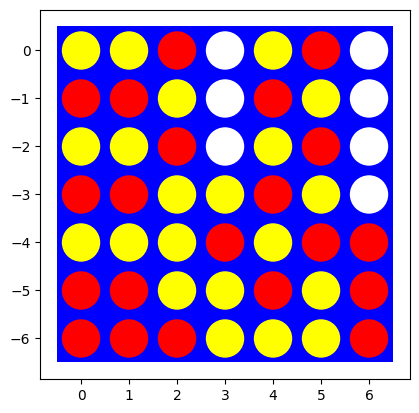


Yellow (Player 2) wins!


In [328]:
# Create two heuristic minimax players with different depths
heuristic_player_depth3 = HeuristicMinimaxPlayer(max_depth=3)
heuristic_player_depth5 = HeuristicMinimaxPlayer(max_depth=5)

# Watch a match between them on a 5x5 board
print("\nWatching a match: Heuristic Minimax depth=3 (Red) vs Heuristic Minimax depth=5 (Yellow)")
watch_match(heuristic_player_depth3, heuristic_player_depth5, board_shape=(7, 7), delay=0.5)


## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [310]:
# Your code/ answer goes here.

### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [311]:
# Your code/ answer goes here.